<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/CFLANN_with_JAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [3]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [4]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [5]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [38]:
class CFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    func1_x = 2*(x ** 2) - 1
    func2_x = 4*(x ** 3) - 3*x
    func3_x = 8*(x ** 4) - 8*(x ** 2) + 1
    functioned_x = np.hstack((x, func1_x, func2_x, func3_x, const_x))
    return functioned_x

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [39]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size):
    self.p_size = p_size
    self.data = []

    for i in range(p_size):
      d = {}
      d['W'] = 2*np.random.random((9*4 + 1, 1)) - 1
      model = CFLANN(d['W'])
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    print(sum([v['mse'][9] for v in self.data]))
    print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += 1.0* np.random.random((9*4 + 1, 1))* (self.data[self.best]['W'] - self.data[i]['W'])
      # t -= np.random.random((9*3 + 1, 1))* (self.data[self.worst]['W'] - self.data[i]['W'])
      model = CFLANN(t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      self.next_gen()
      print(str(self.data[self.best]['mse'][9]) + "\t" + str(self.data[self.worst]['mse'][9]))

In [46]:
optimiser = JAYATFLANN(50)
optimiser.optimise(100)
model = CFLANN(optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


17.079467436239824
[0.4551832989096661, 0.39594051921831436, 0.5828835392329432, 0.5446456149088135, 0.5326796899671484, 0.08548988609879517, 0.08720028350478128, 0.2232157565229274, 0.5245234374060715, 0.5337099839251037, 0.57240609435029, 0.589461900305051, 0.5352187082794616, 0.5627872652658318, 0.041973210961716814, 0.024077358573214178, 0.57234021018702, 0.5753076936752927, 0.05638656097482683, 0.22147585500463396, 0.3466302001571477, 0.12697445972751675, 0.5612814651846902, 0.415102770562915, 0.5848112486754342, 0.5389706172637558, 0.4335822504131815, 0.22618290845941036, 0.07289722129251423, 0.48430201103418336, 0.49876705609998884, 0.48534244127944515, 0.04173936787274756, 0.05472363435750282, 0.038833659360452896, 0.09192301733065115, 0.5779414888384016, 0.5797355375138998, 0.5736257540916077, 0.5568645717704845, 0.05014622141364158, 0.5304625588514977, 0.08091826160694579, 0.08442381133181912, 0.05181184291219764, 0.5687055834766787, 0.1343255357445824, 0.17576435238296756, 0

In [47]:
preds[:, 0]

array([0.17039643, 0.16689848, 0.17417855, 0.16948202, 0.17624368,
       0.17642673, 0.16639415, 0.15565646, 0.15583131, 0.15366309,
       0.14889113, 0.15343206, 0.16947356, 0.17229673, 0.18219009,
       0.19582654, 0.20199039, 0.19620297, 0.19528903, 0.20213386,
       0.20701858, 0.22226237, 0.26544304, 0.31021045, 0.35361729,
       0.40342623, 0.42610525, 0.45399199, 0.3585496 , 0.33123362,
       0.27439912, 0.29815945, 0.32341942, 0.3462455 , 0.33585836,
       0.34884783, 0.31097424, 0.36613519, 0.41051093, 0.46764574,
       0.47155968, 0.42362868, 0.39703511, 0.35529727, 0.35822218,
       0.37234143, 0.32680137, 0.301511  , 0.25332714, 0.27179758,
       0.28265119, 0.31426844, 0.33181327, 0.32723684, 0.33736724,
       0.35896916, 0.37860908, 0.44465704, 0.45535478, 0.5043762 ,
       0.50386555, 0.51100121, 0.49802929, 0.50090524, 0.56700656,
       0.62088437, 0.69404805, 0.70711288, 0.69425367, 0.74194289,
       0.76975186, 0.74195107, 0.59724304, 0.68785899, 0.49518

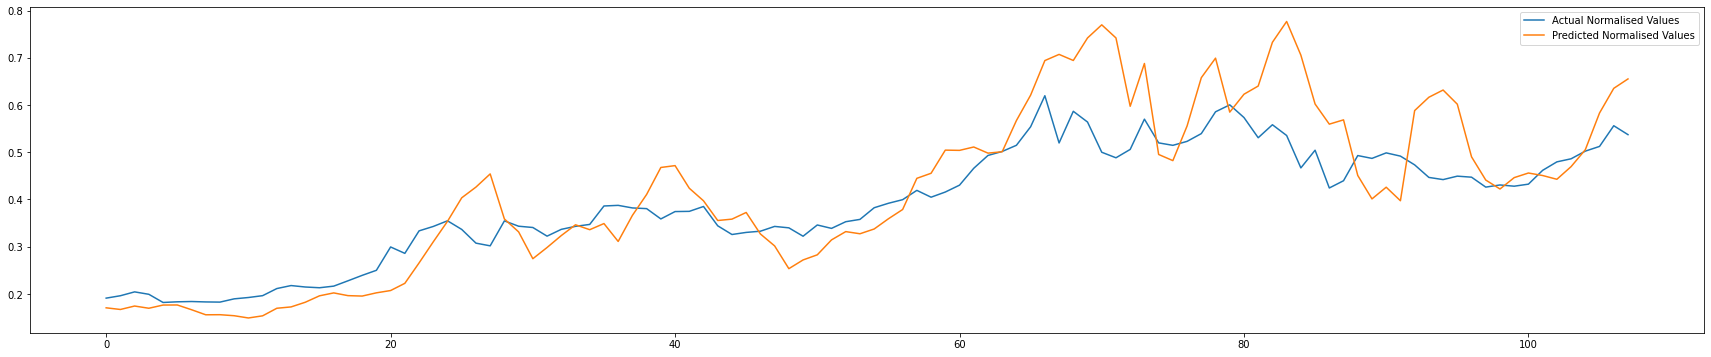

In [48]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [49]:
d1 = (data1max - data1min + 2)[0]
print(type(d1))
denormalized_preds = (preds*d1)[:,0]
# print(denormalized_preds)
denormalized_preds += (data1min + 1)[0]
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

<class 'numpy.float64'>
                       0
DATE                    
2019-04-22   4935.651945
2019-04-23   4873.597414
2019-04-24   5002.747506
2019-04-25   4919.430092
2019-04-26   5039.383386
...                  ...
2019-08-03  10240.725531
2019-08-04  10876.065305
2019-08-05  12255.816477
2019-08-06  13182.122413
2019-08-07  13535.643870

[108 rows x 1 columns]


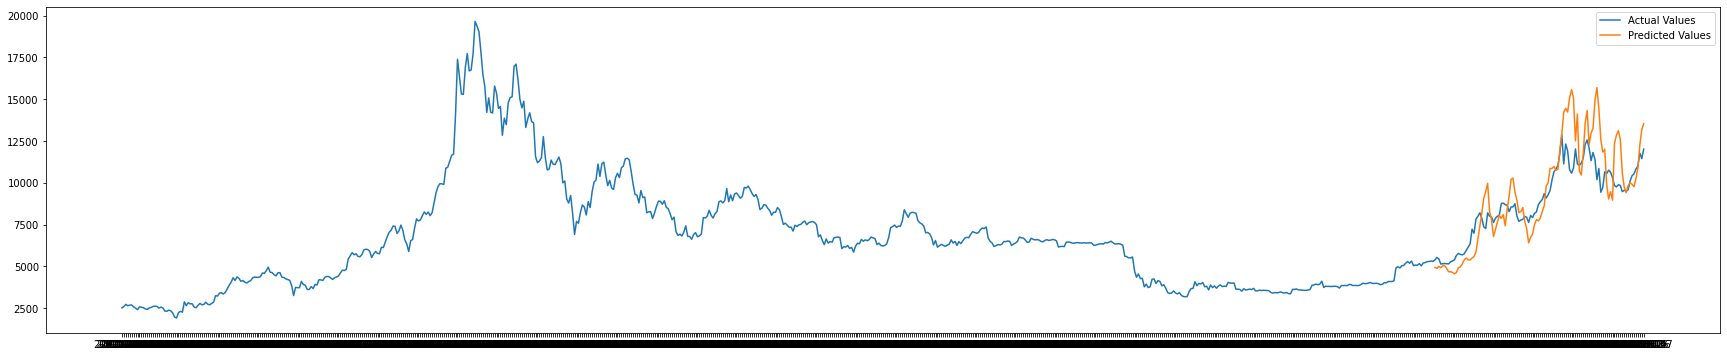

In [50]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [51]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  2543825.9328259337
rmse 1594.9375952763587
